# REPORT ON CLASSIFICATION OF DOPAMINERGIC NEURONS

In this notebook we summarize the results of several attempts at clustering the subset of neurons from the original dataset that were identified as the dopaminergic class into further subclasses.

## I. Dataset preparation

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

First, let us load the original count matrix $M$, the ids of the neurons classified into the dopaminergic class `dopaminergic_neurons`, and some other objects from the original task of classifying monoaminergic neurons into four classes that we will use here.

In [2]:
import pickle
dopaminergic_neurons_ids = pickle.load(open("Pickle/dopaminergic_ids.p", "rb"))
clustering_results = pickle.load(open("Pickle/clustering_results.p", "rb"))
M, _, genes, neurons, _, important_genes_ids, _, experiment_labels, not_always_expressed_genes, _ = pickle.load(open("Pickle/main_info.p", "rb"))

Then, import the libraries and custom defined methods we will use.

In [3]:
import gudhi as gd
exec(open("clustering_methods.py").read());

/home/ziva/miniconda3/envs/monoaminergic/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


<Figure size 640x480 with 0 Axes>

We expect the genes used as the markers for the dopaminergic class to be uniformly highly expressed on this dataset. Similarly, the genes that were used as markers for the other classes are expected to have low expression on the dopaminergic class. We wish to remove such genes from the analysis to decrease the dimension of embeddings (the dimension equals the number of used genes).

First, restric the dataset to dopaminergic neurons only.

In [4]:
dM = M[dopaminergic_neurons_ids,:]
#dM = M

Create filters for the genes used, one based on the maximal expression (this should be sufficiently large to remove genes that are not highly expressed), second based on the minimal expression (this should be sufficiently low to remove genes that are always highly expressed), and third based on the number of neurons on which a specific gene is expressed (this should not be too small and not too big, first to avoid genes that are always expressed and second to avoid genes that are never expressed). We then restrict the count matrix to these genes only, and we also modify the list of gene names. 

In [5]:
maxs = dM.max(axis=0)
N = len(maxs)
mins = dM.min(axis=0)
counts = np.array([dM > 1.5])[0].sum(axis=0)
max_filter = [i for i in range(len(dM[0,:])) if maxs[i] > 10] # we want to remove genes that are not strongly expressed
min_filter = [i for i in range(len(dM[0,:])) if mins[i] < 2] # we want to remove genes that are not always expressed
counts_filter = [i for i in range(len(dM[0,:])) if (counts[i] > 10 and counts[i] < len(dM[:,0]) - 10)] # we want to remove genes that are not expressed or always expressed
print(N-len(max_filter), N-len(min_filter), N-len(counts_filter))

8805 7 5968


/tmp/ipykernel_89489/2238285770.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(range(len(norms)), np.log10(np.sort(norms)[::-1]))


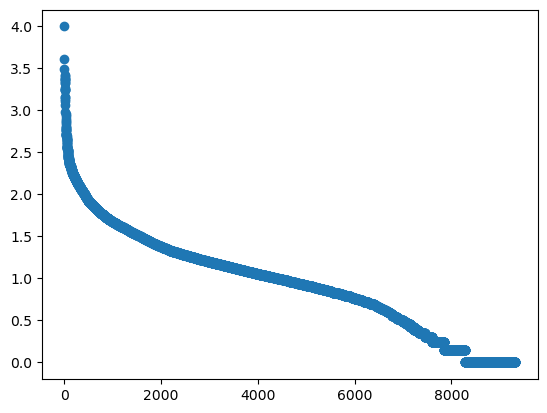

In [6]:
norms = np.linalg.norm(dM,axis=0)
plt.scatter(range(len(norms)), np.log10(np.sort(norms)[::-1]))

In [7]:
norms_filter = [i for i in range(len(dM[0,:])) if np.log10(norms[i]) >= 0.5 and np.log10(norms[i])<=2] # we want to remove genes that are not strongly expressed

/tmp/ipykernel_89489/127293908.py:1: RuntimeWarning: divide by zero encountered in log10
  norms_filter = [i for i in range(len(dM[0,:])) if np.log10(norms[i]) >= 0.5 and np.log10(norms[i])<=2] # we want to remove genes that are not strongly expressed


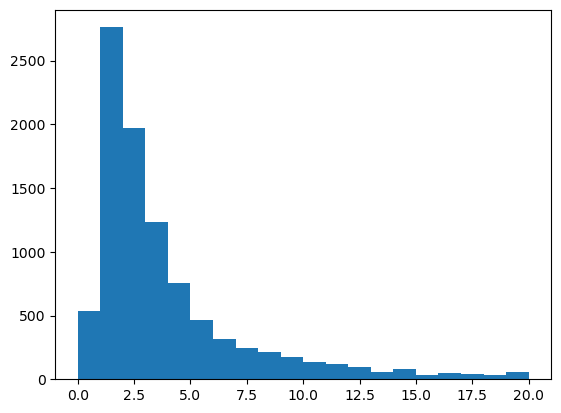

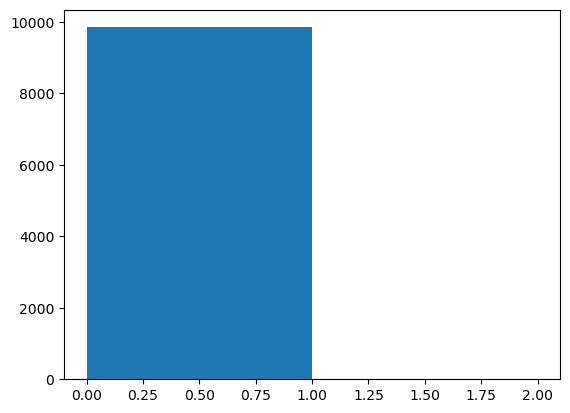

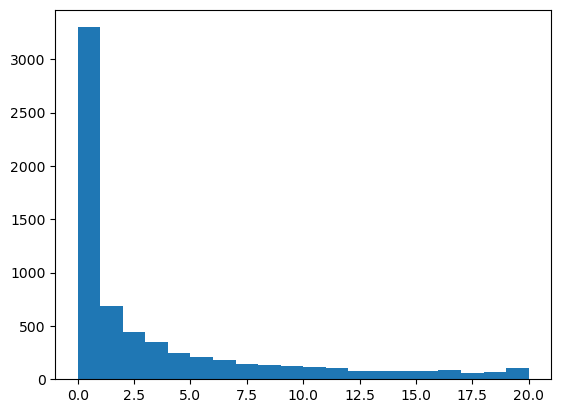

In [8]:
plt.hist(maxs, bins=20, range=(0, 20));
plt.show()
plt.hist(mins, bins=2, range=(0,2));
plt.show()
plt.hist(counts, bins=20, range=(0,20));

In [9]:
filtered = [i for i in max_filter if i in min_filter and i in counts_filter]# and i in norms_filter]
print("Nr of genes after filtering: ", len(filtered))
dM =dM[:,filtered]
genes_og = genes
genes = [genes[i] for i in filtered]

Nr of genes after filtering:  999


In [10]:
dM.shape

(587, 999)

In [11]:
fer2_ids = [i for i in range(len(dopaminergic_neurons_ids)) if dM[i,genes.index('Fer2')] > 1]
fer2_annotations = {'o': fer2_ids}
fer2_legend = {'o': "Expresses Fer2"}

In [12]:
def log_normalization(matrix, base='e'):
    new_matrix = np.zeros(matrix.shape)
    for i, row in enumerate(matrix):
        s = row.sum()
        if base=='e':
            new_matrix[i, :] = np.array([np.log(1 + 10000 * entry / s) for entry in row])
        elif base==2:
            new_matrix[i, :] = np.array([np.log2(1 + 10000 * entry / s) for entry in row])
        if base==10:
            new_matrix[i, :] = np.array([np.log10(1 + 10000 * entry / s) for entry in row])
    return new_matrix

In [13]:
dM_lnnorm = log_normalization(dM)

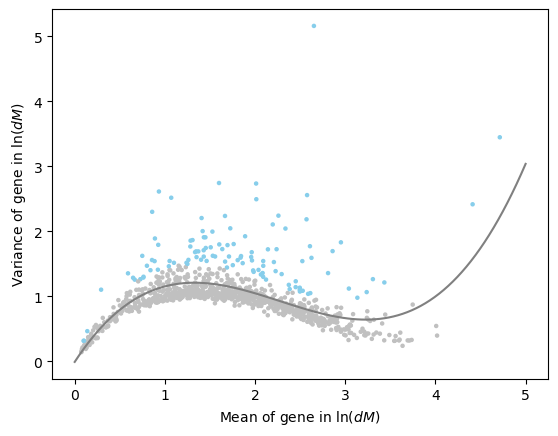

In [14]:
hv_genes=[]
gw_means = dM_lnnorm.mean(axis=0)
gw_var = dM_lnnorm.var(axis=0)
poli = np.polyfit(gw_means, gw_var, 3)
gw_count = np.count_nonzero(dM, axis=0)
c = ['silver']*len(gw_var)
#for i in important_genes_ids:
#    c[i] = 'red'
for i in range(len(gw_means)):
    #if gw_var[i]>=0.05*(1+2*gw_means[i])+1.2*np.poly1d(poli)(gw_means[i]):#0.1+ 0.15*gw_means[i] + np.poly1d(poli)(gw_means[i]):
    if gw_var[i]>=0.05+1.2*np.poly1d(poli)(gw_means[i]):
        c[i]='skyblue'#'pink'
        hv_genes += [i]
plt.scatter(gw_means, gw_var, c=c, s=5)
#plt.scatter([g for i, g in enumerate(gw_means) if i in important_genes_ids],
#            [g for i, g in enumerate(gw_var) if i in important_genes_ids],
#            c='purple', marker='x', s=100)
xs = np.linspace(0,5,100)
plt.plot(xs, np.poly1d(poli)(xs), c='gray')
plt.xlabel("Mean of gene in $\ln(dM)$")
plt.ylabel("Variance of gene in $\ln(dM)$")
plt.show()

In [15]:
len(hv_genes)

112

<Axes: >

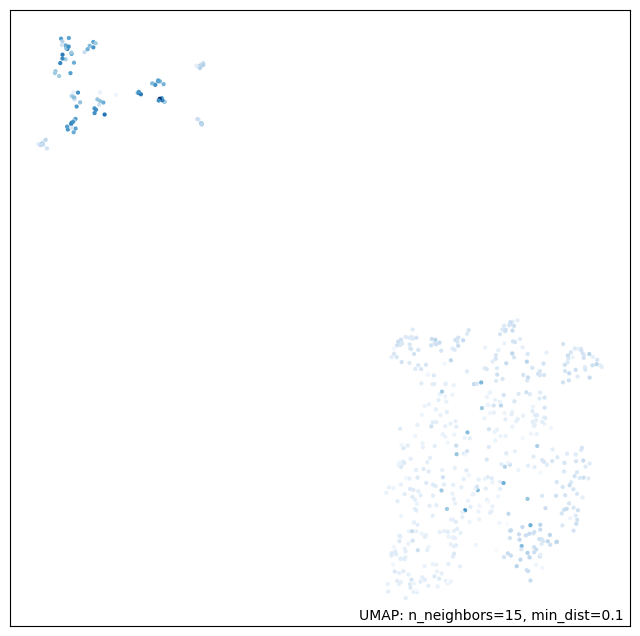

In [16]:
dM_mapper = umap.UMAP(random_state=2400, metric='euclidean').fit(dM_lnnorm)
#umap.plot.points(dM_mapper, values=np.sqrt(dM[:, genes.index('Fer2')]))
umap.plot.points(dM_mapper, values=np.linalg.norm(dM, axis=1), alpha=1)
# vs = np.var(dM, axis=1)
# ms = np.mean(dM, axis=1)
# umap.plot.points(dM_mapper, values=ms/vs)

In [17]:
Ns = np.linalg.norm(dM, axis=1)
print(Ns.max(), Ns.min())

900.8051953669006 23.769728648009426


## II. Clustering

### II.1 Clustering dM

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


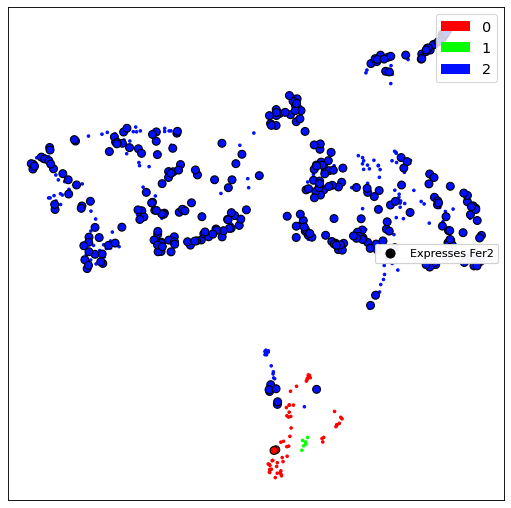

In [18]:
dM_clusters, dM_mapper, dM_PD, dM_D = visualize_kcluster(dM, 3, 6, annotate=fer2_annotations, legend_text=fer2_legend)
vals = np.sort([pt[1]/pt[0] for pt in dM_PD])[::-1]

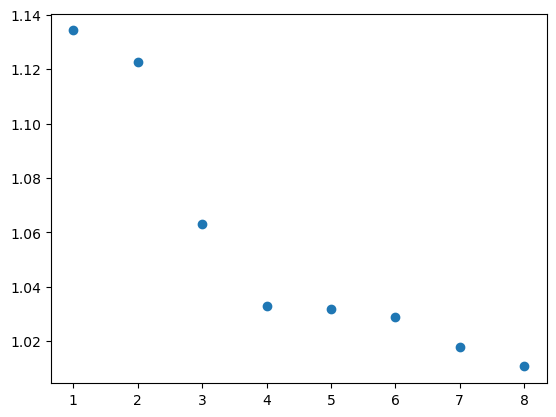

In [19]:
plt.scatter(range(len(vals)), vals)

We save the information about these clusters for future analysis.

In [20]:
dM_clusters_dict = convert_list_to_dict(dM_clusters)
dM_annotation_dict, dM_legend_text = get_plot_annotations(dM_clusters_dict, legend_suffix=" (dM)")

In [21]:
for i in dM_clusters_dict.keys():
    print(i, len(dM_clusters_dict[i]))

0 55
1 6
2 526


### Identifying discriminative genes

To see which genes drive this separation into different clusters, we need to measure the strength of expression of each gene on each cluster. Our strategy is as follows.
		
For each gene $g$ compute the median $\text{med}(g)$ of its expression on dopaminergic neurons (we could also choose the mean or some other statistical estimate). Let $C = \{i_1, i_2, \ldots, i_{n_C}\}$ be a cluster identified by our clustering analysis, in this case this information is collected in `dM_clusters_dict` where the key is the cluster label and the identifiers are indices of rows belonging to neurons in said cluster. We take the percentage of neurons in $C$ whose expression is bigger than $\text{med}(g)$ to be the measure of expression of gene $g$ on cluster $C$, and denote it by $M(g, C)$. The higher this value is, the stronger the expression of gene $g$ is on $C$.
		
We summarize the results of these computations with tables where we write $M(g, C)$ in row belonging to gene $g$ and column belonging to cluster $C$. For this clustering we only show rows belonging to genes whose minimum value of $M(g, C)$ over all clusters is below $0.1$ and maximum value is above $0.9$.

In [22]:
_, df = table_clusterwise_expression(dM, dM_clusters_dict, range(len(genes)), genes, method = 'median')
cm = sns.light_palette("green", as_cmap=True)
dfproj = df[df.max(axis=1)>=0.99]
dfproj = dfproj[dfproj.min(axis=1)<=0.01]
s = dfproj.style.background_gradient(cmap=cm, axis=None)
s

,0,1,2


### II.2 Clustering ln(dM)

We normalize the data and obtain a clustering via kcluster.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


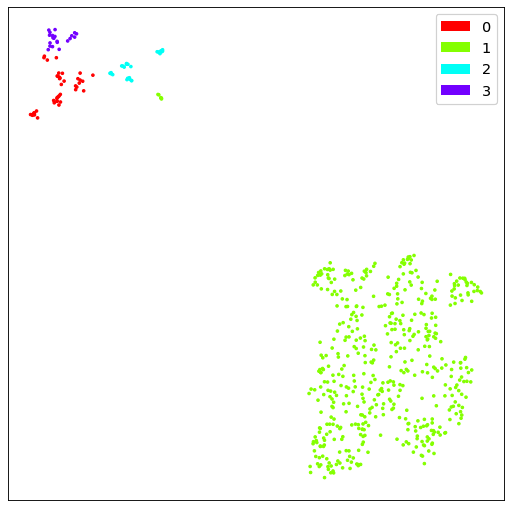

In [23]:
ln_clusters, ln_mapper, ln_PD, _ = visualize_kcluster(dM_lnnorm, 4, 6)
vals = np.sort([pt[1]/pt[0] for pt in ln_PD])[::-1]
ln_clusters_dict = convert_list_to_dict(ln_clusters)
ln_annotation_dict, ln_legend_text = get_plot_annotations(ln_clusters_dict, legend_suffix=" ($\ln(dM)$)")

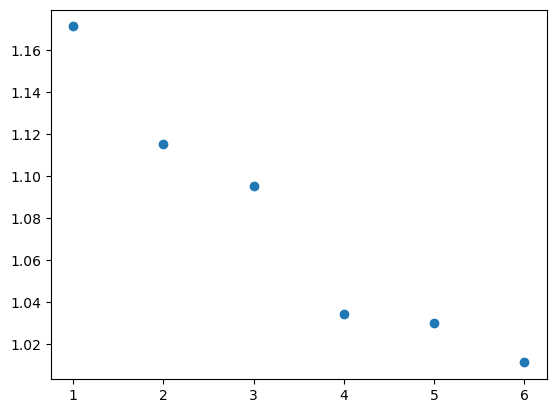

In [24]:
plt.scatter(range(len(vals)), vals)

### Identifying discriminative genes

We compute values $M(g, C)$ for this clustering as well. We again show only the rows belonging to genes whose minimum value of $M(g, C)$ over all clusters is below $0.05$ and maximum value is above $0.8$.

In [25]:
_, df = table_clusterwise_expression(dM_lnnorm, ln_clusters_dict, range(len(genes)), genes, method = 'median')
cm = sns.light_palette("green", as_cmap=True)
dfproj = df[df.max(axis=1)>=0.8]
dfproj = dfproj[dfproj.min(axis=1)<=0.05]
s = dfproj.style.background_gradient(cmap=cm, axis=None)
s

,0,1,2,3
Ets65A,0.813953,0.000000,0.000000,0.000000
CG14459,0.488372,0.022177,0.962963,0.000000
sli,0.395349,0.522177,0.000000,0.809524
CG6044,0.558140,0.487903,1.000000,0.000000
Nep1,0.186047,0.024194,1.000000,0.238095
Lim1,0.093023,0.530242,0.962963,0.000000
dac,0.000000,0.028226,0.962963,0.285714
fd102C,0.651163,0.010081,0.000000,0.904762


### II.2 Clustering with cosine distance

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


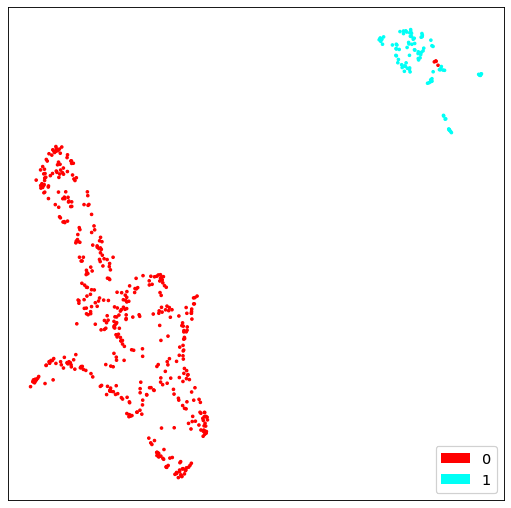

In [26]:
cos_clusters, cos_mapper, cos_PD, rowwise_D = visualize_kcluster(dM, 2, 8, metric='cosine', loc_clusterlegend=4)
vals = np.sort([pt[1]/pt[0] for pt in cos_PD])[::-1]
cos_clusters_dict = convert_list_to_dict(cos_clusters)
cos_annotation_dict, cos_legend_text = get_plot_annotations(cos_clusters_dict, legend_suffix=" (dM)")

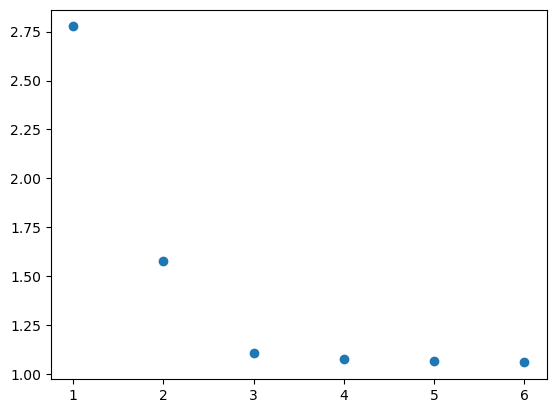

In [27]:
plt.scatter(range(len(vals)), vals)

### Identifying discriminative genes

We compute values $M(g, C)$ for this clustering as well. We again show only the rows belonging to genes whose minimum value of $M(g, C)$ over all clusters is below $0.1$ and maximum value is above $0.9$.

In [28]:
_, df = table_clusterwise_expression(dM, cos_clusters_dict, range(len(genes)), genes, method = 'median')
cm = sns.light_palette("green", as_cmap=True)
dfproj = df[df.max(axis=1)>=0.7]
dfproj = dfproj[dfproj.min(axis=1)<=0.05]
s = dfproj.style.background_gradient(cmap=cm, axis=None)
s

,0,1


### II.3 Clustering on a subset of highly expressed genes

Next, we remove some more columns belonging to relatively uniformly expressed genes from $dM$. First, we count how many times each gene is expressed on dopaminergic neurons and remove the genes whose counts are smaller than $100$ or bigger than $358 = 458-100$ (where $458$ is the total number of dopaminergic neurons). Further, we compute the maximal expression of a gene on dopaminergic neurons and remove the genes for which it is below $20$. (These thresholds we chose are completely arbitrary, but we give justification below that our clustering results are relatively consistent over different choices of thresholds.)

In [29]:
counts = np.count_nonzero(dM, axis=0)
maxs = np.max(dM, axis=0)

In [30]:
len(dM)

587

In [31]:
expression_filter = [i for i, v in enumerate(counts) if (v>=50 and v<=537)]
#max_filter = [i for i, v in enumerate(maxs) if (v>=20)]
filtered_ids = [i for i in expression_filter if maxs[i]>=10]

In [32]:
len(filtered_ids)

798

In addition, apply square root to each entry and run `kcluster` with parameters `n_clusters=4` and `k_value=10`. Denote the obtained clusters by $i (dMf)$, where $i$ is the cluster id.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


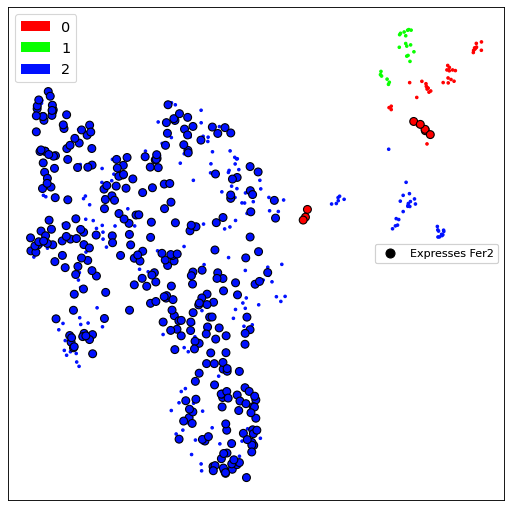

In [33]:
filtered_clusters, filtered_mapper, filtered_PD, filtered_D = visualize_kcluster(log_normalization(dM[:,filtered_ids]), 3, 4, loc_clusterlegend=2, annotate=fer2_annotations, legend_text=fer2_legend, metric='euclidean')
filtered_clusters_dict = convert_list_to_dict(filtered_clusters)
filtered_annotation_dict, filtered_legend_text = get_plot_annotations(filtered_clusters_dict, legend_suffix=" (dMf)")
vals = np.sort([pt[1]/pt[0] for pt in filtered_PD])[::-1]

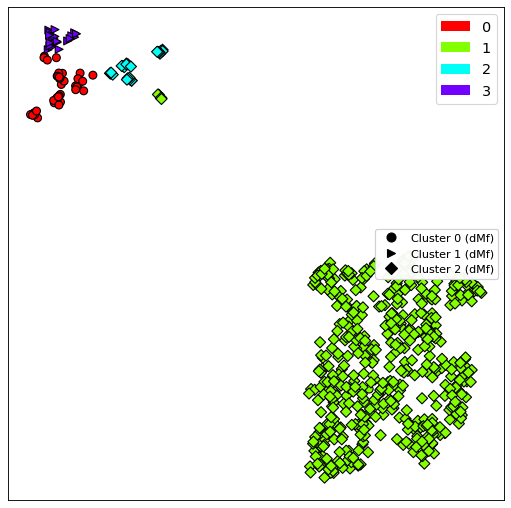

In [34]:
visualize_umap(ln_mapper, ln_clusters, annotate=filtered_annotation_dict, legend_text=filtered_legend_text)

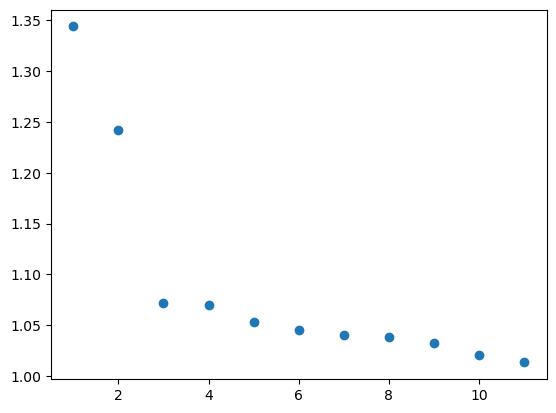

In [35]:
plt.scatter(range(len(vals)), vals)

### Identifying discriminating genes

As before, we compute values $M(g, C)$ for this clustering and show them in a table. We again show only the rows belonging to genes whose minimum value of $M(g, C)$ over all clusters is below $0,1$ and maximum value is above $0.9$.

In [36]:
filtered_genes = [genes[i] for i in filtered_ids]
_, df = table_clusterwise_expression(dM[:, filtered_ids], filtered_clusters_dict, range(len(filtered_ids)), filtered_genes, method = [1]*len(filtered_ids))#'median')
cm = sns.light_palette("green", as_cmap=True)
dfproj = df[df.max(axis=1)>=0.8]
dfproj = dfproj[dfproj.min(axis=1)<=0.05]
s = dfproj.style.background_gradient(cmap=cm, axis=None)
s

method type is list, this is a custom threshold


,0,1,2
mCherry,0.250000,0.000000,0.825670
orb,0.613636,1.000000,0.049808
fd102C,0.477273,0.904762,0.001916


Remember, to obtain this clustering, we filtered out some genes whose expression was deemed not interesting enough on this set of points. Therefore the genes for which we computed the above values were not all genes. Below we display values $M(g, C)$ for genes that were filtered out, but have interesting cluster-wise expression.

In [37]:
_, df = table_clusterwise_expression(dM, filtered_clusters_dict, range(len(genes)), genes, method = [1]*len(genes))#'median')
cm = sns.light_palette("green", as_cmap=True)
dfproj = df[df.max(axis=1)>=0.8]
dfproj = dfproj[dfproj.min(axis=1)<=0.05]
indexdf = [i for i, gene in enumerate(dfproj.index) if genes.index(gene) not in filtered_ids]
s = dfproj.iloc[indexdf].style.background_gradient(cmap=cm, axis=None)
s

method type is list, this is a custom threshold


,0,1,2


### II.4 Clustering on the projection to genes detected in feature selection

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


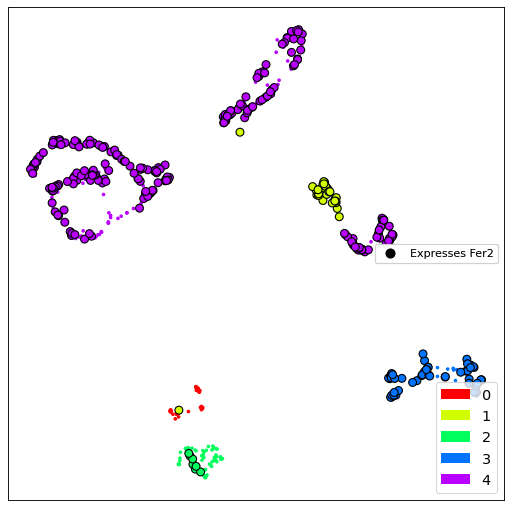

In [38]:
fs_clusters, fs_mapper, fs_PD, fs_D = visualize_kcluster(np.sqrt(dM[:,hv_genes]), 5, 8, loc_clusterlegend=4, metric="euclidean", annotate=fer2_annotations, legend_text=fer2_legend)
fs_clusters_dict = convert_list_to_dict(fs_clusters)
fs_annotation_dict, fs_legend_text = get_plot_annotations(fs_clusters_dict, legend_suffix=" (dMf)")
vals=np.sort([pt[1]/pt[0] for pt in fs_PD])[::-1]

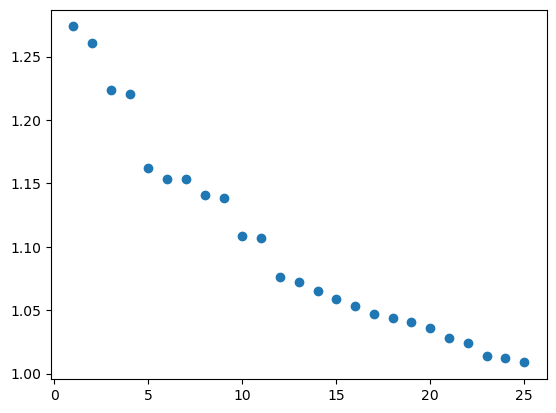

In [39]:
plt.scatter(range(len(vals)), vals)

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


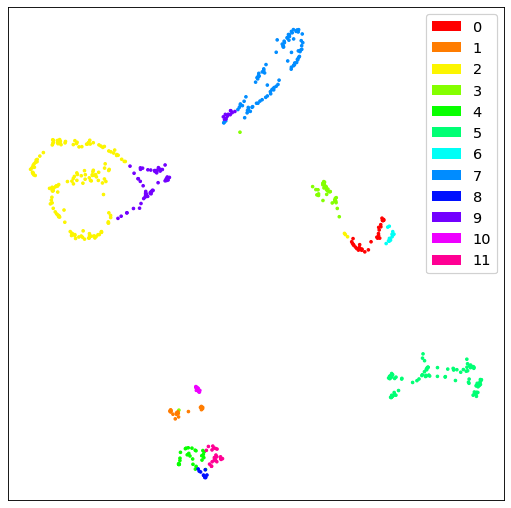

In [40]:
_ = visualize_kcluster(np.sqrt(dM[:,hv_genes]), 12, 8, loc_clusterlegend=1, metric="euclidean")


Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


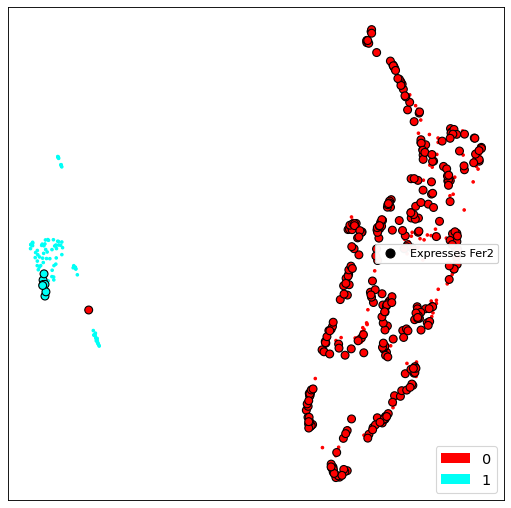

In [41]:
fscos_clusters, fscos_mapper, fscos_PD, fscos_D = visualize_kcluster(dM[:,hv_genes], 2, 8, loc_clusterlegend=4, metric="cosine", annotate=fer2_annotations, legend_text=fer2_legend)
fscos_clusters_dict = convert_list_to_dict(fscos_clusters)
fscos_annotation_dict, fscos_legend_text = get_plot_annotations(fscos_clusters_dict, legend_suffix=" (fscos)")
vals=np.sort([pt[1]/pt[0] for pt in fscos_PD])[::-1]

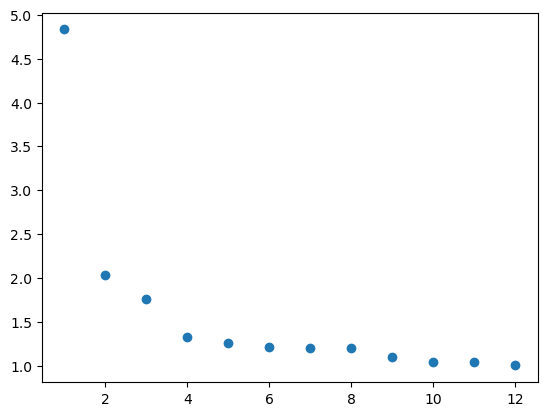

In [42]:
plt.scatter(range(len(vals)), vals)

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


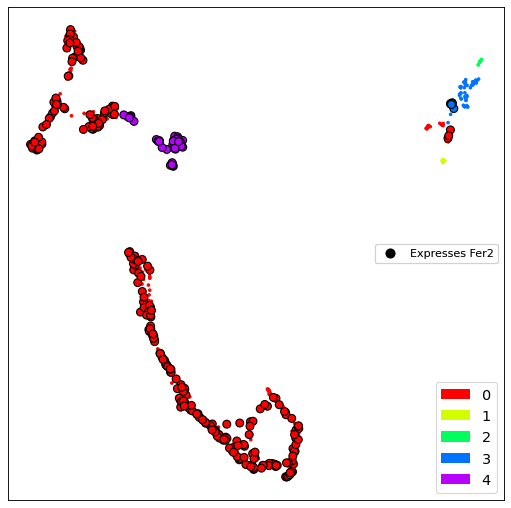

In [43]:
lnhs_clusters, lnhs_mapper, PD, _ = visualize_kcluster(dM_lnnorm[:,hv_genes], 5, 8, loc_clusterlegend=4, annotate=fer2_annotations, legend_text=fer2_legend) # n = 5,6, ali 11
vals = np.sort([pt[1]/pt[0] for pt in PD])[::-1]
lnhs_clusters_dict = convert_list_to_dict(lnhs_clusters)
lnhs_annotation_dict, lnhs_legend_text = get_plot_annotations(lnhs_clusters_dict, legend_suffix=" (lnhs)")

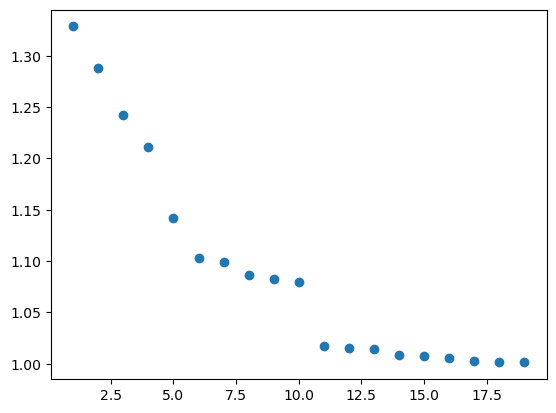

In [44]:
plt.scatter(range(len(vals)), vals)

In [45]:
# dMhv = log_normalization(dM[:,hv_genes])
# lnhscos_clusters, lnhscos_mapper, PD, _ = visualize_kcluster(dMhv, 6, 6, loc_clusterlegend=4, annotate=fer2_annotations, legend_text=fer2_legend, metric='cosine') # n = 5,6, ali 11
# vals = np.sort([pt[1]/pt[0] for pt in PD])[::-1]
# lnhscos_clusters_dict = convert_list_to_dict(lnhscos_clusters)
# lnhscos_annotation_dict, lnhscos_legend_text = get_plot_annotations(lnhscos_clusters_dict, legend_suffix=" (lnhs)")
# plt.scatter(range(len(vals)), vals)

### Identifying discriminative genes

We compute values $M(g, C)$ for this clustering as well. We again show only the rows belonging to genes whose minimum value of $M(g, C)$ over all clusters is below $0.1$ and maximum value is above $0.9$.

In [46]:
# _, df = table_clusterwise_expression(dM_rowwise, rowwise_clusters_dict, range(len(genes)), genes, method = 'median')
# cm = sns.light_palette("green", as_cmap=True)
# dfproj = df[df.max(axis=1)>=0.9]
# dfproj = dfproj[dfproj.min(axis=1)<=0.1]
# s = dfproj.style.background_gradient(cmap=cm, axis=None)
# s

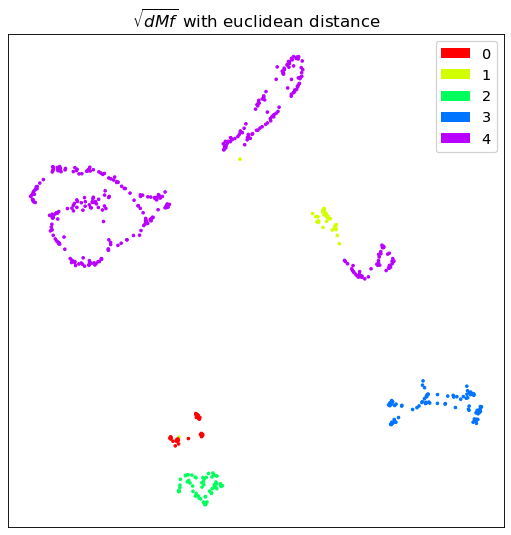

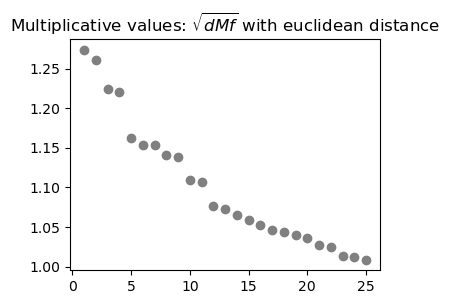

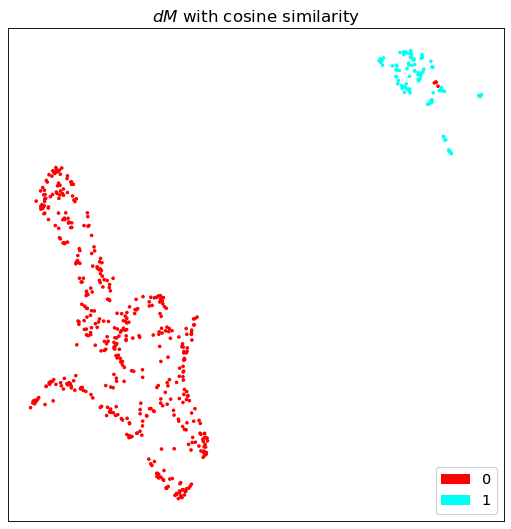

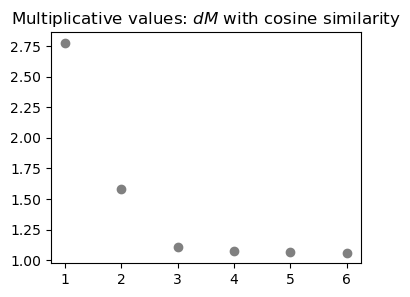

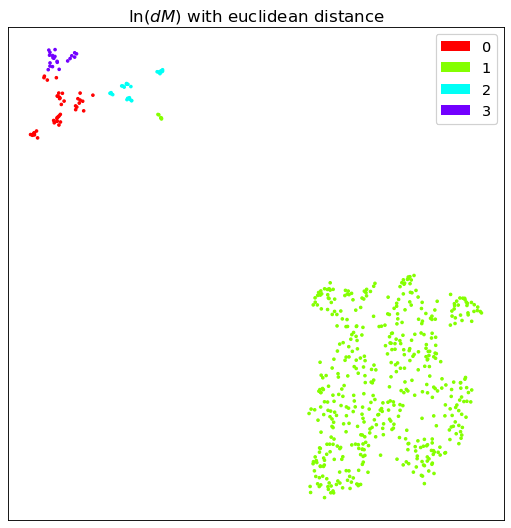

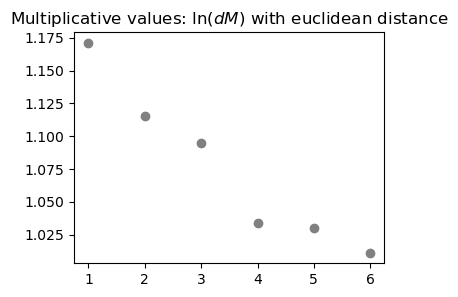

In [47]:
interesting_clusters = [fs_clusters, cos_clusters, ln_clusters]#, fscos_clusters]
interesting_mappers = [fs_mapper, cos_mapper, ln_mapper]#, fscos_mapper]
interesting_PDs = [fs_PD, cos_PD, ln_PD]#, fscos_PD]
interesting_titles = ["$\sqrt{dMf}$ with euclidean distance", "$dM$ with cosine similarity", "$\ln(dM)$ with euclidean distance", "fscos"]
i=0
for cl, mapper, tit, PD in zip(interesting_clusters, interesting_mappers, interesting_titles, interesting_PDs):
    i+=1
    if i==2:
        visualize_umap(mapper, cl, loc_clusterlegend=4, title=tit)#"Dopaminergic neurons: Clustering on "+tit)
        fig, ax = plt.subplots(figsize=(4,3))
        ax.scatter(range(len(PD)),np.sort([pt[1]/pt[0] for pt in PD])[::-1], c='gray')
        ax.set_title("Multiplicative values: "+tit)
        #fig.figsize
    else:
        visualize_umap(mapper, cl,title=tit)#"Dopaminergic neurons: Clustering on "+tit)
        fig, ax = plt.subplots(figsize=(4,3))
        ax.scatter(range(len(PD)),np.sort([pt[1]/pt[0] for pt in PD])[::-1], c='gray')
        ax.set_title("Multiplicative values: "+tit)

In [48]:
help(plt)

Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    an implicit,  MATLAB-like, way of plotting.  It also opens figures on your
    screen, and acts as the figure GUI manager.
    
    pyplot is mainly intended for interactive plots and simple cases of
    programmatic plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The explicit object-oriented API is recommended for complex plots, though
    pyplot is still usually used to create the figure and often the axes in the
    figure. See `.pyplot.figure`, `.pyplot.subplots`, and
    `.pyplot.subplot_mosaic` to create figures, and
    :doc:`Axes API </api/axes_api>` for the plotting methods on an Axes::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.

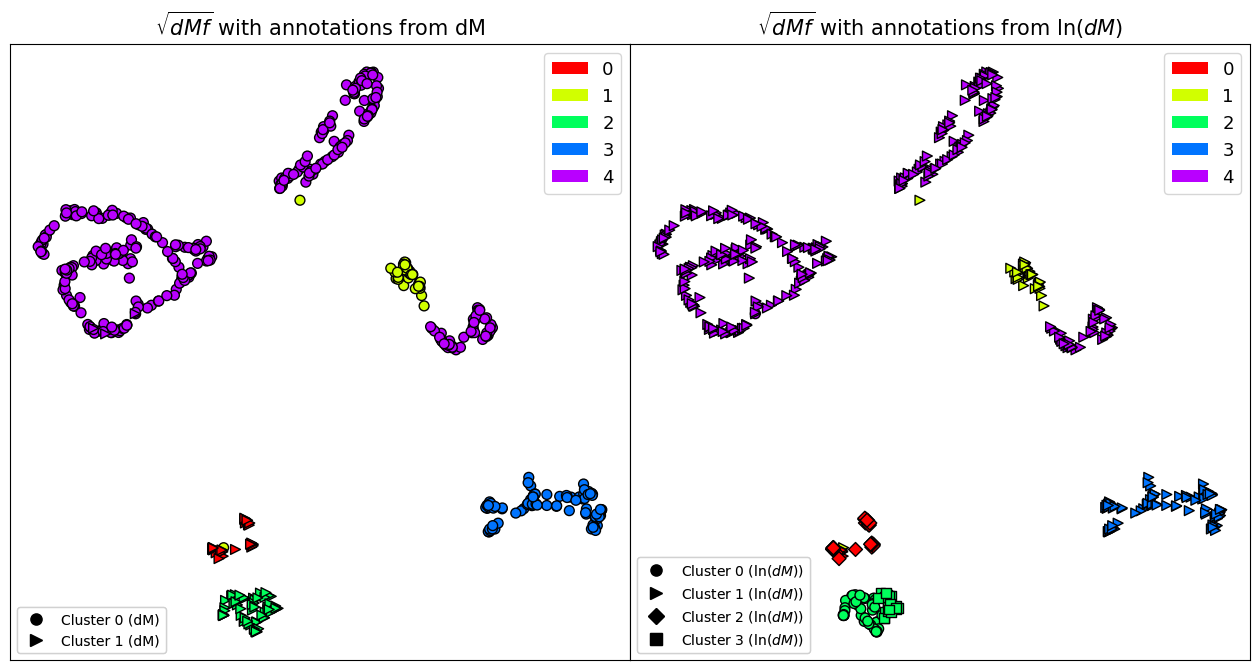

In [49]:
interesting_annotations = [fs_annotation_dict, cos_annotation_dict, ln_annotation_dict]#, filtered_annotation_dict]
interesting_legend_texts = [fs_legend_text, cos_legend_text, ln_legend_text]#, filtered_legend_text]
interesting_titles = ["$\sqrt{dMf}$", "dM", "$\ln(dM)$"]#, "dMf"]
fig, axes = plt.subplots(1,2, figsize = (16,8))
j=0
for ann, leg, title_ann in zip(interesting_annotations, interesting_legend_texts, interesting_titles):
    if j!=0:
        visualize_umap(fs_mapper, fs_clusters, annotate=ann, legend_text=leg, title=interesting_titles[0] + " with annotations from "+title_ann, loc_clusterlegend=1, loc_replegend=3, axis=axes[j-1])
    j+=1
    # for map, cl, title_umap in zip(interesting_mappers, interesting_clusters, interesting_titles):
    #     i+=1
    #     if i!=j:
    #         if i ==2:
    #             visualize_umap(map, cl, annotate=ann, legend_text=leg, title=title_umap + " with annotations from " + title_ann, loc_clusterlegend=2)
    #         elif i==3:
    #             visualize_umap(map, cl, annotate=ann, legend_text=leg, title=title_umap + " with annotations from " + title_ann, loc_replegend=3)
    #         else:
    #             visualize_umap(map, cl, annotate=ann, legend_text=leg, title=title_umap + " with annotations from " + title_ann, loc_replegend=2)
plt.subplots_adjust(wspace=0)

In [61]:
combined_clusters_dict = {}
for clid in fs_clusters_dict.keys():
    if clid == 2:
        cluster = fs_clusters_dict[2]
        cl2 = [i for i in cluster if i in ln_clusters_dict[0]]
        combined_clusters_dict[2] = cl2
        combined_clusters_dict[5] = [i for i in cluster if i not in cl2]
    else:
        combined_clusters_dict[clid] = fs_clusters_dict[clid]
combined_annotation_dict, combined_legend_text = get_plot_annotations(combined_clusters_dict, legend_suffix=" (combined)")

In [62]:
def latexify_table(df, times_100=True, color_pallete="seagreen", threshold_max=0.9, threshold_min=0.1, format_nrs="{:,.1f}", column_width='50px', save_to=None):
    if times_100:
        df = df*100
        threshold_max = threshold_max*100
        threshold_min = threshold_min*100
    cm = sns.light_palette(color_pallete, as_cmap=True)
    dfproj = df[df.max(axis=1)>=threshold_max]
    dfproj = dfproj[dfproj.min(axis=1)<=threshold_min]
    s = dfproj.style.background_gradient(cmap=cm, axis=None)
    columns = list(df.columns)
    s.format({key: format_nrs.format for key in columns})
    s.set_properties(subset=columns, **{'width': column_width})
    s.set_properties(**{'text-align': 'center'})
    latex_table = s.to_latex(
        convert_css=True,
        hrules=True,
        caption="Placeholder caption",
        label="tab:new_table",
        column_format = 'c'*(len(columns)+1)
        )
    if save_to is not None:
        with open(save_to, "w") as f:
            f.write(latex_table)
    return latex_table, s

In [74]:
_, df = table_clusterwise_expression(M[dopaminergic_neurons_ids,:], combined_clusters_dict, range(len(genes_og)), genes_og, method = [1]*len(genes_og))#'median')
_, s = latexify_table(df, threshold_max=0.85, threshold_min=0.05)#, save_to="Tables/combined_clusters_marker_table.tex")
s

method type is list, this is a custom threshold


,0,1,2,3,4,5
mCherry,0.0,91.9,21.4,79.2,90.2,0.0
Fer2,0.0,86.5,16.7,55.2,65.4,0.0
CG17193,36.4,94.6,2.4,16.7,40.2,14.3
Sar1,57.6,27.0,59.5,2.1,11.2,95.2
orb,48.5,13.5,64.3,0.0,1.4,100.0
CG15522,42.4,0.0,11.9,0.0,0.6,90.5
emc,78.8,5.4,54.8,2.1,2.8,90.5
GluRIA,54.5,0.0,69.0,2.1,7.8,95.2
GluRIB,54.5,5.4,66.7,1.0,9.8,100.0
cmpy,97.0,8.1,45.2,3.1,41.6,42.9


In [67]:
combined_clusters = [0]*len(fs_clusters)
for key in combined_clusters_dict.keys():
    for i in combined_clusters_dict[key]:
        combined_clusters[i] = key

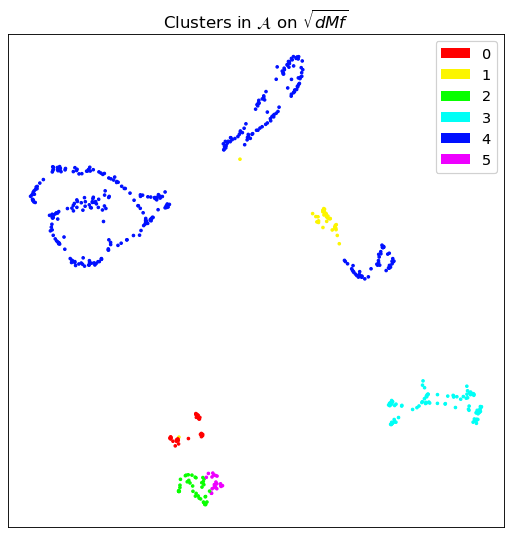

In [70]:
visualize_umap(fs_mapper, combined_clusters, title = "Clusters in $\mathcal{A}$ on $\sqrt{dMf}$")

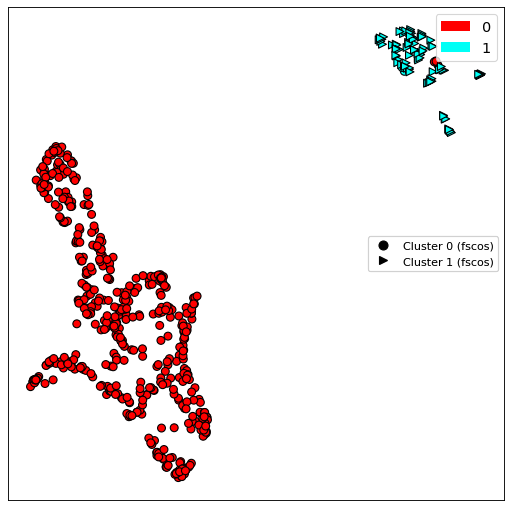

In [53]:
visualize_umap(cos_mapper, cos_clusters, annotate=fscos_annotation_dict, legend_text=fscos_legend_text )

In [54]:
# cl0 = cos_clusters_dict[0]
# dMcl0 = dM[cl0,:]
# dMcl0_clusters, _, PD, _ = visualize_kcluster(dMcl0, 3, 6, metric='cosine')
# plt.scatter(range(len(PD)),np.sort([pt[1]/pt[0] for pt in PD])[::-1])
# cl0_clusters = np.zeros(np.array(cos_clusters).shape, dtype=int)
# for i, j in enumerate(cl0):
#     cl0_clusters[j] = dMcl0_clusters[i]+1

In [55]:
#visualize_umap(cos_mapper, cl0_clusters)

In [56]:
# cl0_dict = convert_list_to_dict(cl0_clusters)
# cl0_annotation_dict, cl0_legend_text = get_plot_annotations(cl0_dict, legend_suffix=" (cos+cl0)")

## IV. Comparisson of clustering results (and combined clustering)

We notice that the three different sets of clusters obtained in section II. fit together nicely. We illustrate this by plotting two of them in the same plot.

In [57]:
annotations = [dM_annotation_dict, ln_annotation_dict, cos_annotation_dict, filtered_annotation_dict, fs_annotation_dict, lnhs_annotation_dict, fscos_annotation_dict]
legend_texts = [dM_legend_text, ln_legend_text, cos_legend_text, filtered_legend_text, fs_legend_text, lnhs_legend_text, fscos_legend_text]
descriptions=["dM", "ln", "cos", "dMf", "fs", "lnhs", "fscos"]

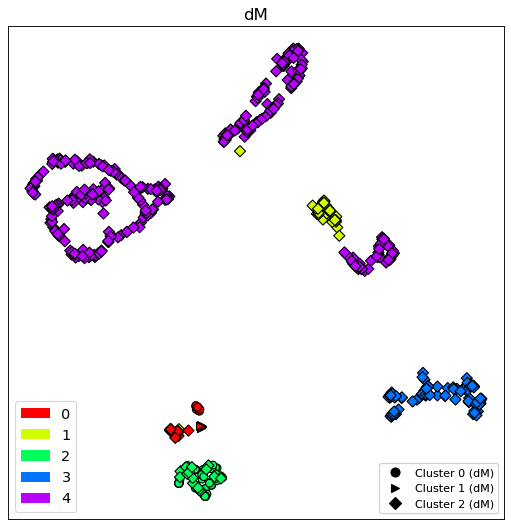

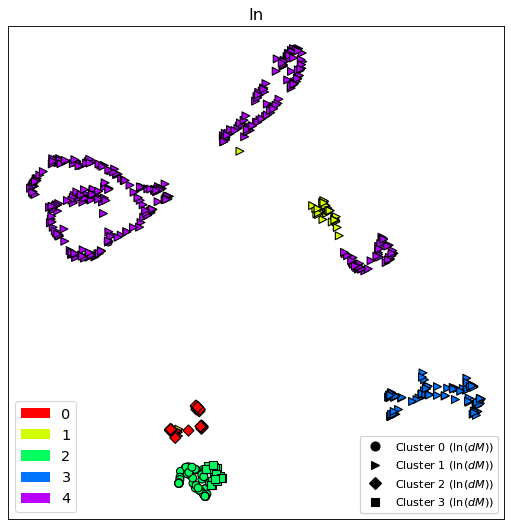

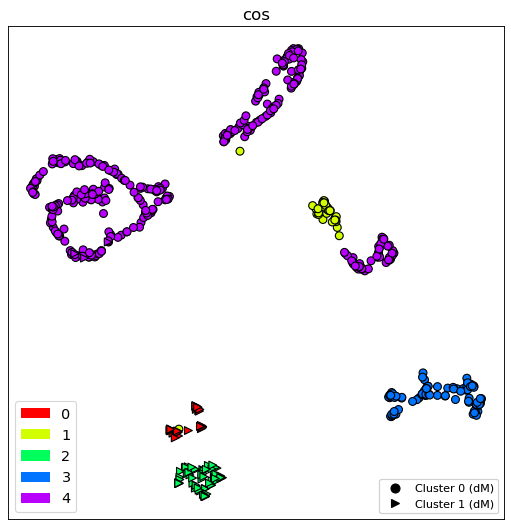

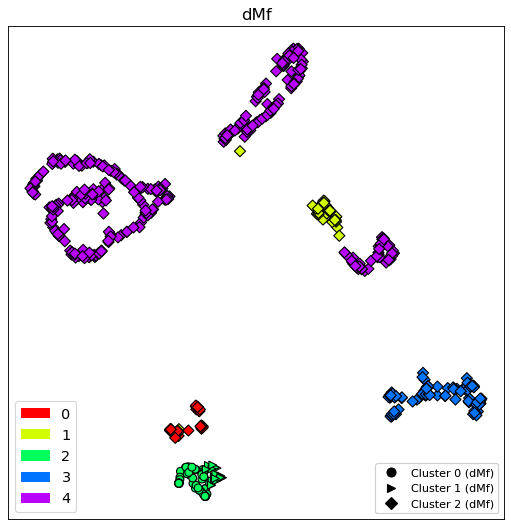

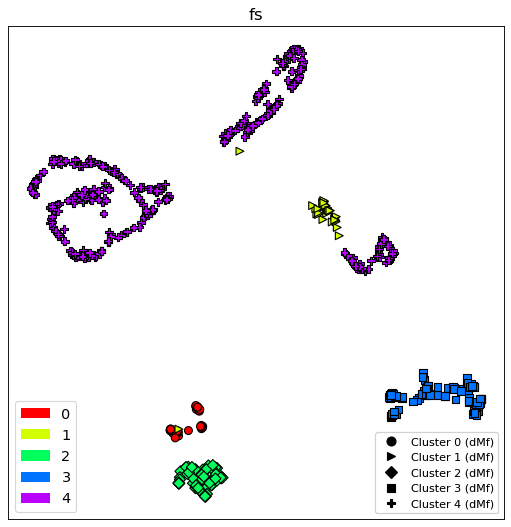

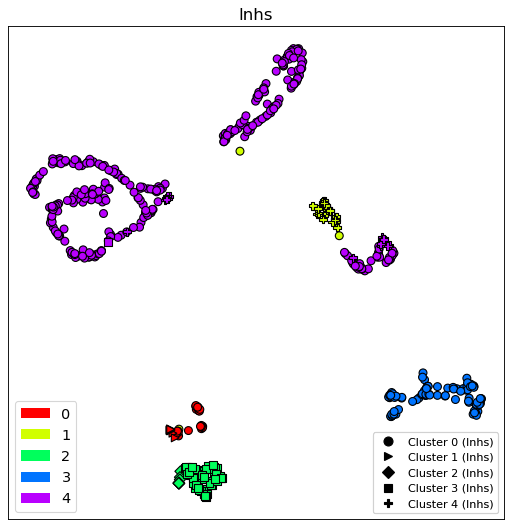

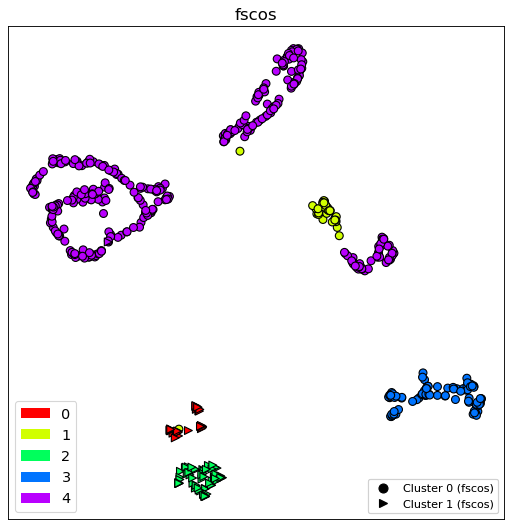

In [58]:
for i, annotation in enumerate(annotations):
    visualize_umap(fs_mapper, fs_clusters, annotate=annotation, legend_text=legend_texts[i], title=descriptions[i], loc_clusterlegend=3, loc_replegend=4)

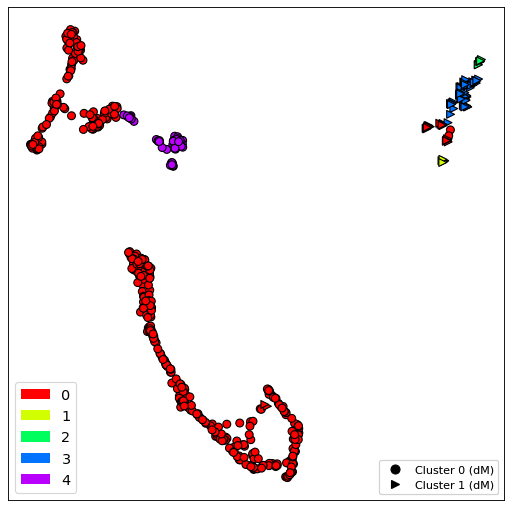

In [59]:
visualize_umap(lnhs_mapper, lnhs_clusters, annotate=cos_annotation_dict, legend_text=cos_legend_text, loc_clusterlegend=3, loc_replegend=4)